In [3]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### The dataset consists of 3 .csv files. we will concatenate them.

In [56]:
# the dataset consists of 3 .csv files. we will concatenate them.
data1 = pd.read_csv('data//articles1.csv',index_col=0)
data2 = pd.read_csv('data//articles2.csv',index_col=0)
data3 = pd.read_csv('data//articles3.csv',index_col=0)

In [100]:
data = pd.concat([data1, data2, data3])
data.shape

(142570, 9)

In [101]:
data.head()

,id,title,publication,author,date,year,month,url,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


In [102]:
data.isnull().sum()

id                 0
title              2
publication        0
author         15876
date            2641
year            2641
month           2641
url            57011
content            0
dtype: int64

In [103]:
data.dropna(subset=['title'], inplace = True)
data.isnull().sum()

id                 0
title              0
publication        0
author         15875
date            2641
year            2641
month           2641
url            57011
content            0
dtype: int64

### Distribution of publications

In [104]:
Counter(data.publication)

Counter({'New York Times': 7803,
         'Breitbart': 23781,
         'CNN': 11488,
         'Business Insider': 6757,
         'Atlantic': 7179,
         'Fox News': 4354,
         'Talking Points Memo': 5213,
         'Buzzfeed News': 4854,
         'National Review': 6203,
         'New York Post': 17493,
         'Guardian': 8681,
         'NPR': 11992,
         'Reuters': 10709,
         'Vox': 4947,
         'Washington Post': 11114})

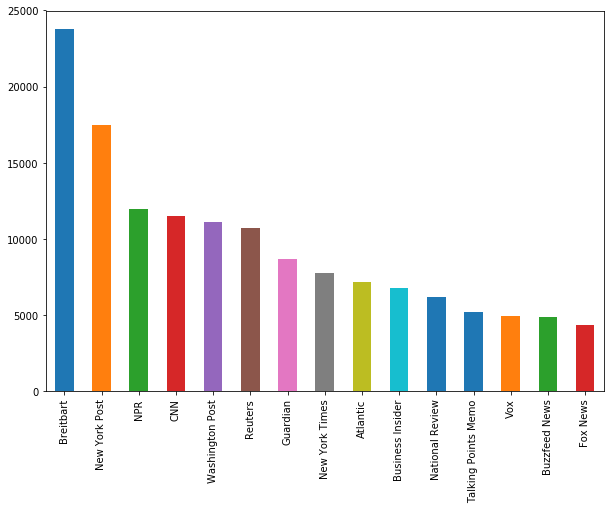

In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
data.publication.value_counts().plot(kind='bar')

In [63]:
from tqdm import tqdm, tqdm_notebook

In [65]:
import spacy
from spacy import displacy
nlp = spacy.load('en')

In [67]:
frames = []
for i in tqdm_notebook(range(1000)):
    doc = data.loc[i,'content']
    text_id = data.loc[i,'id']
    doc = nlp(doc)
    ents = [(e.text, e.start_char, e.end_char, e.label_) 
            for e in doc.ents 
            if len(e.text.strip(' -—')) > 0]
    frame = pd.DataFrame(ents)
    frame['id'] = text_id
    frames.append(frame)

In [69]:
npf = pd.concat(frames)
npf.head(10)

,0,1,2,3,id
0,WASHINGTON,0,10,GPE,17283
1,Republicans,30,41,NORP,17283
2,Obama,116,121,PERSON,17283
3,Trump,167,172,NORP,17283
4,billions of dollars,317,336,MONEY,17283
5,Americans,377,388,NORP,17283
6,House,398,403,ORG,17283
7,Republicans,404,415,NORP,17283
8,millions,556,564,CARDINAL,17283
9,Republicans,617,628,NORP,17283


In [74]:
npf.columns = ['Text','Start','Stop','Type','id']

### Distribution of types of predefined words

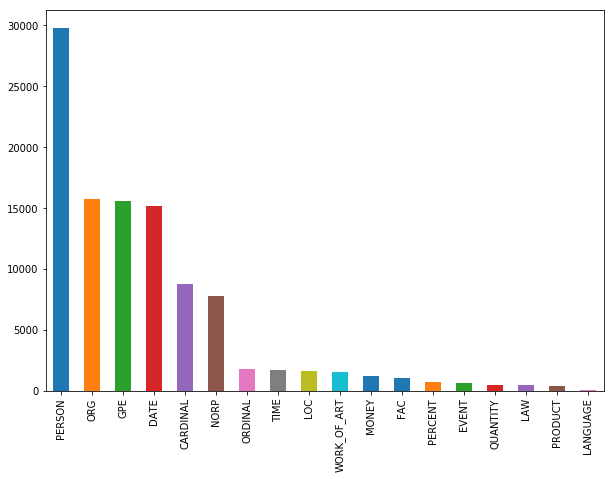

In [75]:
plt.figure(figsize=(10,7))
npf.Type.value_counts().plot(kind='bar')

### Organizations that are commonly featured

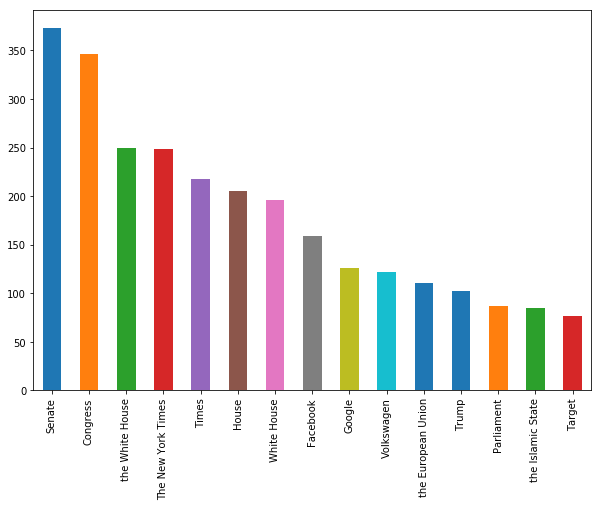

In [76]:
orgs = npf[npf.Type == 'ORG']
plt.figure(figsize=(10,7))
orgs.Text.value_counts()[:15].plot(kind='bar')

### Individuals that are commonly featured

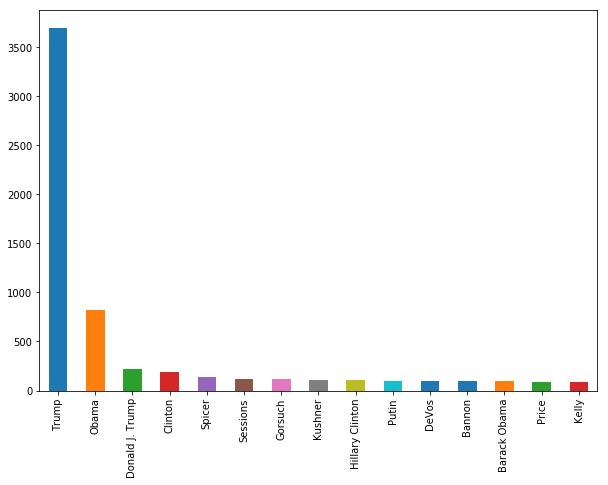

In [78]:
orgs = npf[npf.Type == 'PERSON']
plt.figure(figsize=(10,7))
orgs.Text.value_counts()[:15].plot(kind='bar')

### Topics in titles

In [81]:
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [82]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yidingweng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [83]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yidingweng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [93]:
import gensim
import random
from gensim import corpora
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [86]:
title_data = []
title_df = data['title']
for line in title_df:
    tokens = prepare_text_for_lda(line)
    if random.random() > .99:
        print(tokens)
        title_data.append(tokens)

['house', 'republican', 'winning', 'health', 'times']
['china', 'fan', 'patriotism', 'years', 'japan', 'history', 'book', 'times']
['uconn', 'woman', 'straight', 'rewrite', 'history', 'times']
['power', 'small', 'nation', 'china', 'mostly', 'times']
['julie', 'taymor', 'direct', 'clive', 'butterfly’', 'times']
['trust', 'record', 'trump', 'still', 'closely', 'empire', 'times']
['begging', 'liberia', 'street', 'heating', 'club', 'night', 'times']
['highlight', 'ruling', 'trump', 'immigration', 'order', 'times']
['woman', 'retire', 'times']
['question', 'going', 'investment', 'times']
['review', 'little', 'lies,’', 'monterey', 'clichés', 'times']
['force', 'crucial', 'mosul', 'times']
['ingrid', 'lafleur', 'artist', 'curator', 'enter', 'detroit', 'mayoral', 'times']
['worker', 'safety', 'rule', 'among', 'trump', 'times']
['pentagon', 'release', 'photo', 'rebut', 'contention', 'bomb', 'mosque', 'times']
['want', 'trump', 'bet', 'expert', 'gambling', 'website', 'times']
['trump', 'congress

['comey', 'trump', 'flynn', 'request', 'inappropriate', 'sound', 'captain', 'courageous’', 'breitbart']
['’remain’', 'activist', 'attack', 'event', 'attendee']
['medium', 'suddenly', '’courage’', 'stand', 'first', 'amendment']
['donald', 'trump', 'gang', 'getting', 'going', 'prison’']
['leftist', 'journos', 'target', 'conservative', 'student', 'fundraise', 'event', 'breitbart']
['migrant', 'construction', 'worker', 'allegedly', 'cause', 'death', '5-year']
['canadian', 'organization', 'resident', 'register', 'racist', 'breitbart']
['’overwatch’', 'take', 'award', 'breitbart']
['baltimore', '’crisis’', 'officer', 'shortage', 'month', 'police', 'policy']
['matthew', 'trump', 'russia', 'collusion', 'theory', '’came', 'apart’', 'comey', 'testimony', 'breitbart']
['border', 'patrol', 'agent', 'seize', 'mexican', 'border']
['trump', '’resistance’', 'try', 'fail', 'imitate', 'party']
['first', 'trump', 'keeping', 'promise', 'breitbart']
['wear', 'predictable', 'result', 'ensue']
['senate', 're

['facebook', 'delete', 'popular', 'shade', 'room’', 'breitbart']
['donald', 'trump', 'scores', 'vega', 'rally', 'phenomenon’', 'breitbart']
['scarborough', 'rather', 'fire’', 'participate', 'debate', 'megyn', 'kelly', 'breitbart']
['despite', 'opposition', 'conclusion', 'negotiator', 'brussels']
['plan’', 'marco', 'rubio', 'drop', 'presidential', 'breitbart']
['harry', 'pulling', 'trump', 'breitbart']
['limbaugh', 'really', 'like’', 'marco', 'rubio', 'breitbart']
['’anti', 'semitic', 'images’', 'place', 'presidential', 'campaign’', 'breitbart']
['visit', 'trump', 'tower', 'seeking', 'area', 'common', 'ground’', 'breitbart']
['trump', 'teaching', 'supporter', 'brownshirts’', 'hitler', 'putin’']
['useful', 'idiot', '’conservative’', 'pundit', 'democrat', 'parlor', 'trick', 'breitbart']
['pride', 'goeth', 'ail', 'call', 'trump', 'daughter']
['italy', 'overtake', 'greece', 'prime', 'arrival', 'point', 'migrant']
['baiting', 'oxford', 'rhodes', 'scholar', 'assault', 'white', 'student', 'bla

['clinton', 'fundraiser', 'donald', 'trump', 'debate']
['doubt', 'russia', 'claim', 'kill', 'spokesman']
['reason', 'wells', 'fargo', 'scheme', 'scary']
['syria', 'temporary', 'ceasefire', 'begin', 'skepticism']
['twitter', 'chill', 'lochte', 'protest']
['piper', 'perabo', 'seek', 'thrill', '’notorious’']
['blood', 'could', 'tailor', 'treatment', 'depression']
['101-year', 'harley']
['reality', 'check', 'trump', 'debate', 'excuse']
['trump', 'duck', 'question', 'yucca', 'mountain']
['republican', 'control', 'congress']
['reason', 'expect', 'hillary', 'clinton', 'prosecute']
['ronaldo', 'trick', 'beats', 'atletico', 'madrid', 'derby']
['wisconsin', 'official', 'speedy', 'recount', 'defend', 'tally']
['trump', 'speak', '’about', 'every']
['elector', 'trump']
['donald', 'trump', 'think']
['protester', 'champagne', 'leader']
['’howard', 'stern', 'show’', 'personality', 'boot']
['stun', 'vintage', 'photo', 'american', 'dream']
['kerry', 'state', 'solution', '’serious', 'jeopardy’']
['carrie

['trump', 'still', 'understand', 'holocaust']
['voting', 'right', 'trial', 'bayou']
['legal', 'standing', 'range', 'parent']
['reaction']
['obama', 'equal', 'rule']
['hospital', 'serve', 'mcdonald']
['walking']
['millennials', 'almost', 'kill']
['prepare', 'inevitable', 'level']
['southpaw', 'havana']
['hogan', 'gawker', 'public', 'arena']
['atlantic', 'daily', 'iceland', 'meltdown', 'haven', 'wisconsin', 'primary']
['sander', 'ground']
['bryantâ€']
['harriet', 'tubman', 'journey']
['barack', 'obama', 'comedian', 'chief']
['lawsuit', 'virginia', 'felon', 'voting']
['ghomeshi', 'legal']
['trump', 'campaign']
['stream', 'suicide']
['international', 'space', 'station', 'first', 'german', 'commander']
['barcelona', 'reclaim', 'flag']
['dying']
['atlantic', 'daily', 'orlando', 'victim', 'mateen', 'motive', 'qatar', 'victim']
['bernie', 'sander', 'ballot', 'effect']
['return', 'enthusiasm']
['labor', 'software', 'update', 'tinderbox', 'scrivener']
['track', '’tangled', 'blue’', 'dylan']
['pa

['trump', 'allow']
['kentucky', 'governor', 'sign', 'single', 'marriage', 'license']
['boehner']
['different']
['speaker', '’better’', 'boehner']
['sheriff', 'sign', 'trauma', 'prince', 'reason', 'believe’', 'death', 'suicide']
['south', 'carolina', 'sheriff', 'naacp', 'racist', 'group’']
['authorities', 'shoot', 'outside', 'kill']
['north', 'carolina', 'violate', 'civil', 'right']
['heidi', 'compare', 'husband', 'white', 'house', 'effort', 'slavery']
['california', 'weather', 'blame', 'unpredictable', 'pineapple', 'express']
['pretend', 'producer', 'trick', 'woman', 'going']
['reason', 'potential', 'writer', 'strike']
['hundred', 'victim', 'family', 'member', 'sue', 'saudi', 'arabia']
['ban', 'laptop', 'tablet', 'flight', 'major', 'middle', 'eastern', 'airport']
['military', 'troops']
['crowdsourced', 'russia', 'twitter', 'investigation', 'prompt', 'harassment', 'complaint']
['really', 'big', 'party', 'queer', 'woman', 'country']
['house', 'conservative', 'craft', 'change', 'republica

['firing', 'medium', 'fight']
['parent', 'internet', 'stab', 'victim', 'suspect']
['family', 'delta', 'agent', 'smacking', 'phone']
['kevin', 'kline', 'award', 'without', 'campaigning']
['woman', 'invent', 'fidget', 'spinner', 'getting', 'squat']
['draymond', 'green', 'advise', 'medium', 'headline', 'story']
['charge', 'dismiss', 'couple', 'accused', 'fuel', 'threesome']
['barclays', 'regrets', 'try', 'whistleblower']
['disney', 'original', 'disneyland', 'could']
['probe', 'show', 'act', 'forthrightly’']
['blasio', 'expert', 'fake']
['untouchable', 'ranger', 'bench']
['depot', 'buck', 'sluggish', 'retail', 'trend']
['happy', 'rainbow', 'bright', 'look']
['metro', 'north', 'train', 'derail', 'connecticut']
['baywatch’', 'reboot', 'celeb', 'ogle']
['dirty', 'dancing’', 'natured', 'musical', 'remake']
['spots', 'asteroid', 'earth']
['british', 'authorities', 'intel', 'following', 'bombing', 'leak']
['makeup', 'artist', 'slam', 'turning', 'white', 'model', 'black']
['homeless', 'save', 'ma

['german', 'police', 'explosive', 'syrian', 'national']
['survive', 'believe', 'protest', 'barricade', 'uterus']
['mcdonald', 'take', 'virtual', 'tours', 'actual', 'supplier', 'farm']
['keith', 'scott', 'shooting', 'video', 'emerge', 'fatal', 'encounter', 'charlotte', 'police']
['light', 'fantastic', 'minimalism', 'thrive', 'hampton']
['traynor', 'obituary']
['trump’', 'facebook', 'deepen', 'millennials’', 'confirmation']
['reveal', 'russia', 'spill', 'deepwater', 'horizon']
['nuclear', 'weapon', 'foreign', 'hotspot', 'could', 'trump', 'finger', 'trigger']
['burton', 'peregrine', 'flies', 'weekend', 'office']
['bridget', 'jones', 'female', 'character', 'billion', 'dollar']
['clinton', 'fatal', 'police', 'shooting', '’protecting', 'children’']
['prepare', 'trump', 'presidency']
['military', 'vessel', 'point', 'weapon', 'helicopter', 'pentagon', 'official']
['acquisition', 'univision']
['child', 'refugee', 'calais', 'journey', 'over’']
['south', 'finale', 'troll', 'create', 'chaos', '’br

['street', 'dollar', 'surge', 'higher', 'trump']
['kellogg', 'switch', 'delivery', 'model', 'snack', 'costs']
['thousand', 'continue', 'protest', 'government', 'romania']
['trillion', 'street', 'trade', 'trump']
['exclusive', 'burger', 'hortons', 'owner', 'popeyes', 'source']
['iraqi', 'force', 'battle', 'islamic', 'state', 'reach', 'mosul', 'airport']
['stateless', 'rohingya', 'refugee', 'suck', 'boom', 'bangladesh', 'trade']
['gambia', 'president', 'barrow', 'remove', 'senior', 'officer']
['economy', 'slow', 'fourth', 'quarter', 'despite', 'robust', 'consumer', 'spending']
['bitcoin', 'approval', 'intensify']
['tesla', 'offer', 'south', 'australia', 'power', 'crisis']
['canadian', 'fintech', 'take', 'private', 'billion']
['south', 'korean', 'prosecutor', 'group', 'official', 'questioning']
['kill', 'paris', 'airport', 'plan', 'allah’', 'prosecutor']
['iraqi', 'force', 'close', 'mosul', 'mosque', 'strike', 'kill', 'foreign', 'militant']
['black', 'lawmaker', 'trump', 'infrastructure',

['zadie', 'smith', 'introduce', 'protégé']
['brexit', 'result', 'scientist', 'terrify']
['obama', 'donald', 'trump', 'populist']
['record', 'setting', 'terrible', 'movie', 'sequel']
['olympics', 'opening', 'ceremony', 'getting', 'better']
['doctor', 'tooth', 'floss', 'enough', 'floss']
['worthy', 'show', 'marathon', 'weekend', 'american', 'crime', 'superstore']
['colin', 'powell', 'leak', 'email', 'elite', 'rarely', 'admit', 'publicly']
['formula', 'selling', 'million', 'dollar']
['debate', 'moderator', 'campaign', 'trump']
['white', 'people', 'hometown', 'prefer', 'trump']
['trump', 'first', 'office', 'include', 'sue', 'woman', 'accuse', 'assault']
['gingrich', 'fight', 'megyn', 'kelly', 'reveal', 'gross', 'twist', 'logic', 'sexual', 'assault']
['racist', 'attack', 'tammy', 'duckworth', 'patriotism', 'familiar', 'people', 'color']
['conversation', 'trumpism', 'roger', 'stone', 'dirty', 'trickster', 'trump', 'close']
['trump', 'obamacare', 'birth', 'control', 'congress']
['donald', 'tr

In [87]:
title_dictionary = corpora.Dictionary(title_data)
title_corpus = [title_dictionary.doc2bow(title) for title in title_data]
import pickle
pickle.dump(title_corpus, open('title_corpus.pkl', 'wb'))
title_dictionary.save('title_dictionary.gensim')

In [89]:
NUM_TOPICS = 10
title_ldamodel = gensim.models.ldamodel.LdaModel(title_corpus, num_topics = NUM_TOPICS, id2word=title_dictionary, passes=15)
title_ldamodel.save('title_model10.gensim')

In [90]:
title_topics = title_ldamodel.print_topics(num_words=8)
for topic in title_topics:
    print(topic)

(0, '0.011*"trump" + 0.010*"times" + 0.009*"clinton" + 0.008*"congress" + 0.006*"report" + 0.005*"point" + 0.005*"want" + 0.005*"obama"')
(1, '0.014*"trump" + 0.008*"breitbart" + 0.008*"think" + 0.008*"obama" + 0.005*"state" + 0.005*"election" + 0.004*"clinton" + 0.004*"rule"')
(2, '0.018*"trump" + 0.007*"force" + 0.007*"woman" + 0.006*"times" + 0.005*"assault" + 0.005*"tesla" + 0.005*"breitbart" + 0.005*"people"')
(3, '0.042*"trump" + 0.015*"donald" + 0.006*"american" + 0.005*"could" + 0.005*"people" + 0.005*"north" + 0.005*"campaign" + 0.005*"state"')
(4, '0.041*"breitbart" + 0.026*"trump" + 0.008*"obama" + 0.007*"clinton" + 0.006*"times" + 0.005*"first" + 0.005*"hillary" + 0.005*"attack"')
(5, '0.023*"breitbart" + 0.015*"trump" + 0.007*"times" + 0.006*"obamacare" + 0.006*"student" + 0.005*"fight" + 0.005*"million" + 0.005*"rubio"')
(6, '0.021*"trump" + 0.013*"breitbart" + 0.008*"question" + 0.007*"times" + 0.005*"police" + 0.005*"comey" + 0.004*"woman" + 0.004*"take"')
(7, '0.027*"t

### Topics and key words in all the headlines

In [98]:
prepareData = pyLDAvis.gensim.prepare(title_ldamodel, title_corpus, title_dictionary)
prepareData

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.152948 -0.007820       1        1  13.500839
9      0.011575 -0.098609       2        1  11.180861
3     -0.037822 -0.100303       3        1  10.661579
0     -0.115945  0.071467       4        1  10.000401
7     -0.024626 -0.052237       5        1   9.740405
5      0.026167  0.079242       6        1   9.645207
2     -0.047848 -0.018687       7        1   9.207230
1      0.039744  0.066663       8        1   8.960013
8      0.002951  0.035384       9        1   8.671401
6     -0.007143  0.024900      10        1   8.432056, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
262   Default  109.000000   breitbart  109.000000  30.0000  30.0000
1     Default   19.000000       house   19.000000  29.0000  29.0000
91    Default   30.000000      donald   30.000000  28.0000  28.0000
86    Default   15.000000       white   15.000000  27.0000  27.0000
2     Default   17.000000  republican   17.000000  26.0000  26.0000
44    Default    7.000000    question    7.000000  25.0000  25.0000
213   Default    9.000000       think    9.000000  24.0000  24.0000
29    Default  173.000000       trump  173.000000  23.0000  23.0000
266   Default   12.000000      report   12.000000  22.0000  22.0000
76    Default    9.000000    congress    9.000000  21.0000  21.0000
11    Default   10.000000       years   10.000000  20.0000  20.0000
51    Default    8.000000       force    8.000000  19.0000  19.0000
163   Default   19.000000    american   19.000000  18.0000  18.0000
470   Default   11.000000      medium   11.000000  17.0000  17.0000
591   Default   13.000000      attack   13.000000  16.0000  16.0000
851   Default   16.000000      debate   16.000000  15.0000  15.0000
409   Default   10.000000   obamacare   10.000000  14.0000  14.0000
192   Default   25.000000       state   25.000000  13.0000  13.0000
3     Default   40.000000       times   40.000000  12.0000  12.0000
740   Default    6.000000       point    6.000000  11.0000  11.0000
585   Default    9.000000       comey    9.000000  10.0000  10.0000
330   Default    9.000000     islamic    9.000000   9.0000   9.0000
183   Default    7.000000      policy    7.000000   8.0000   8.0000
214   Default    7.000000     assault    7.000000   7.0000   7.0000
375   Default   26.000000       obama   26.000000   6.0000   6.0000
904   Default    9.000000       fight    9.000000   5.0000   5.0000
1561  Default    6.000000       tesla    6.000000   4.0000   4.0000
263   Default    9.000000     million    9.000000   3.0000   3.0000
574   Default   15.000000    campaign   15.000000   2.0000   2.0000
0     Default    6.000000      health    6.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
1796  Topic10    0.719911      story’    1.335053   1.8555  -6.7955
791   Topic10    0.719911       diana    1.335053   1.8555  -6.7955
585   Topic10    3.337829       comey    9.375829   1.4403  -5.2615
1081  Topic10    2.028871       major    5.353481   1.5029  -5.7594
1052  Topic10    2.021954    democrat    5.374973   1.4954  -5.7628
1381  Topic10    2.023144      answer    5.435049   1.4849  -5.7622
176   Topic10    1.374395    abortion    3.342507   1.5844  -6.1488
149   Topic10    1.373731     popular    3.341925   1.5841  -6.1493
856   Topic10    1.374388     whether    3.351393   1.5818  -6.1488
615   Topic10    2.682174        take    9.399052   1.2191  -5.4802
111   Topic10    3.337854      police   14.260812   1.0209  -5.2615
29    Topic10   13.329629       trump  173.621796  -0.0938  -3.8769
262   Topic10    8.122375   breitbart  109.382652  -0.1271  -4.3722
3     Topic10    4.432702       times   40.934631   0.2502  -4.9778
199   Topic10    2.028866     suspect    6.759210   1.2697  -5.7594
15    Topic10    2.683357       woman   20.49

In [110]:
breitbart = data[data.publication == 'Breitbart']
breitbart_content = breitbart['content']
breitbart_data = []
for line in breitbart_content:
    tokens = prepare_text_for_lda(line)
    if random.random() > .99:
        print(tokens)
        breitbart_data.append(tokens)

['paris', 'facebook', 'target', 'account', 'link', 'france', 'ahead', 'country', 'presidential', 'election', 'worldwide', 'effort', 'misinformation', 'advertisement']
['SCREEN_NAME', 'syria', 'airstrikes', 'think', 'unconstitutional', 'twitter', 'friday', 'business', 'network', 'varney', 'company', 'call', 'strike', 'syria', 'response', 'chemical', 'weapon', 'attack', 'unconstitutional', 'accord', 'president', 'congress', 'question', 'wisdom', 'attack', 'unintended', 'consequence', 'president', 'allow', 'unilaterally', 'prevent', 'imminent', 'attack', 'respond', 'imminent', 'attack', 'attack', 'pearl', 'harbor', 'morning', 'ask', 'congress', 'approval', 'anything', 'think', 'unconstitutional', 'add', 'question', 'whether', 'advisable', 'robust', 'debate', 'everyone', 'gleeful', 'dictator', 'saddam', 'hussein', 'result', 'become', 'strong', 'cry', 'hussein', 'cry', 'topple', 'assad', 'come', 'would', 'islamic', 'rebel', 'perhaps', 'israel', 'assad', 'follow', 'twitter', 'SCREEN_NAME']
[

['president', 'donald', 'trump', 'reporter', 'house', 'majority', 'steve', 'scalise', 'condition', 'worsen', 'since', 'surgery', 'wounded', 'congressional', 'baseball', 'practice', 'wednesday', 'difficult', 'people', 'thought', 'trump', 'solemnly', 'white', 'house', 'trouble', 'great', 'fighter', 'going', 'president', 'visit', 'scalise', 'hospital', 'family', 'entire', 'country', 'pray', 'comment', 'scalise', 'tragedy', 'bring', 'unity', 'partisan', 'climate', 'country', 'steve', 'bring', 'unity', 'country', 'trump', 'feeling', 'steve', 'great', 'sacrifice', 'could', 'unity', 'bring', 'great', 'country', 'trump', 'comment', 'signing', 'executive', 'order', 'spark', 'skill', 'training', 'apprenticeship', 'economy', 'praise', 'capitol', 'police', 'officer', 'return', 'wounded', 'shooter', 'begin', 'shooting', 'right', 'right', 'bullet', 'save', 'life', 'event', 'conclude', 'trump', 'share', 'spirit', 'unity', 'medium', 'e]verybody', 'include', 'reporter', 'bless', 'people', 'laugh', 'ble

['immigration', 'officer', 'call', 'police', 'department', 'backup', 'group', 'local', 'resident', 'surround', 'apparent', 'attempt', 'interfere', 'arrest', 'criminal', 'alien', 'enforcement', 'removal', 'operations', 'officer', 'working', 'queens', 'arrest', 'hardat', 'sampat', 'guyanese', 'national', 'accused', 'burglary', 'illegal', 'removal', 'accord', 'report', 'daily', 'officer', 'foreign', 'national', 'custody', 'begin', 'plead', 'arrest', 'attract', 'attention', 'others', 'nearby', 'local', 'resident', 'surround', 'officer', 'begin', 'shouting', 'attempt', 'arrest', 'officer', 'call', 'police', 'officer', 'assist', 'control', 'crowd', 'sanctuary', 'department', 'correction', 'nycdoc', 'release', 'sampat', 'custody', 'despite', 'immigration', 'detainer', 'place', 'immigration', 'customs', 'official', 'accord', 'official', 'statement', 'report', 'pix11', 'state', 'sampat', 'multiple', 'pending', 'charge', 'queens', 'county', 'criminal', 'court', 'sampat', 'passenger', 'vehicle', 

['friday', 'channel', 'hannity', 'hannity', 'opening', 'monologue', 'react', 'house', 'speaker', 'decision', 'proceed', 'american', 'health', 'would', 'opening', 'salvo', 'republican', 'try', 'dismantle', 'affordable', 'know', 'obamacare', 'hannity', 'argue', 'republican', 'happen', 'future', 'point', 'flaw', 'legislative', 'process', 'improvement', 'however', 'emphasize', 'outcome', 'fault', 'president', 'donald', 'trump', 'clear', 'hannity', 'president', 'trump', 'failure', 'president', 'trump', 'beyond', 'everything', 'power', 'across', 'finish', 'hannity', 'medium', 'democratic', 'opposition', 'reiterate', 'measure', 'take', 'ensure', 'happen', 'follow', 'twitter', 'SCREEN_NAME']
['member', 'stream', 'medium', 'think', 'mellow', 'feelings', 'toward', 'planet', 'enjoy', 'shopping', 'whole', 'food', 'indeed', 'refine', 'thinking', 'vegan', 'course', 'support', 'control', 'oppose', 'death', 'penalty', 'pentagon', 'budget', 'pride', 'voting', 'peace', 'candidate', 'come', 'right', 'ple

['release', 'statement', 'try', 'distance', 'report', 'buzzfeed', 'decision', 'publish', 'unverifiable', 'memo', 'donald', 'trump', 'midday', 'tuesday', 'tweet', 'statement', 'twitter', 'account', 'saying', 'decision', 'publish', 'carefully', 'source', 'reporting', 'operations', 'government', 'vastly', 'different', 'buzzfeed', 'decision', 'publish', 'unsubstantiated', 'memo', 'trump', 'know', 'using', 'buzzfeed', 'decision', 'deflect', 'reporting', 'match', 'major', 'organisation', 'statement', 'continue', 'fully', 'confident', 'reporting', 'represent', 'first', 'amendment', 'protect', 'informing', 'people', 'inner', 'workings', 'government', 'briefing', 'material', 'prepare', 'president', 'obama', 'trump', 'clear', 'publishing', 'details', 'document', 'corroborate', 'report', 'allegation', 'statement', 'pose', 'direct', 'challenge', 'transition', 'trump', 'given', 'member', 'trump', 'transition', 'vocally', 'criticize', 'reporting', 'encourage', 'identify', 'specifically', 'believe', 

['paris', 'paris', 'police', 'letter', 'explode', 'french', 'office', 'international', 'monetary', 'lightly', 'injure', 'person', 'advertisement']
['senator', 'reduce', 'continue', 'bloodshed', 'chicago', 'confirm', 'sessions', 'attorney', 'general', 'executive', 'director', 'chris', 'political', 'response', 'situation', 'immoral', 'confirmsessions', 'http', 'chris', 'SCREEN_NAME', 'december', 'sessions’', 'nomination', 'hearing', 'expect', 'begin', 'fierce', 'opposition', 'progressive', 'group', 'breitbart', 'previously', 'report', 'chicago', 'end', 'nearly', 'homicide', 'chicago', 'tribune', 'report', 'total', 'homicide', 'january', 'december', 'increase', 'nearly', 'homicide', 'figure', 'shooting', 'fatal', 'combine', 'chicago', 'response', 'carnage', 'business', 'usual', 'tribune', 'sum', 'response', 'chicago', 'homicide', 'suggest', 'answer', 'curtail', 'violence', 'know', 'big', 'problem', 'status', 'response', 'chicago', 'crime', 'lackadaisical', 'approach', 'prosecute', 'indivi

['breitbart', 'senior', 'editor', 'appear', 'maher', 'tonight', 'discus', 'speech', 'college', 'campus', 'following', 'berkeley', 'earlier', 'month', 'journalist', 'jeremy', 'scahill', 'pull', 'wednesday', 'cite', 'appearance', 'guest', 'yiannopoulos', 'bridges', 'write', 'scahill', 'statement', 'ample', 'venue', 'hateful', 'diatribe', 'value', 'debate', 'following', 'scahill', 'protest', 'maher', 'defend', 'upcoming', 'appearance', 'liberal', 'continue', 'election', 'follow', 'example', 'people', 'scahill', 'whose', 'view', 'fantasy', 'bedrock', 'liberal', 'principle', 'equality', 'woman', 'respect', 'minority', 'separation', 'religion', 'state', 'speech', 'declare', 'maher', 'response', 'yiannopoulos', 'indeed', 'monster', 'scahill', 'claim', 'might', 'nothing', 'could', 'serve', 'liberal', 'cause', 'better', 'expose', 'friday', 'night']
['election', 'lawyer', 'justice', 'department', 'whistleblower', 'christian', 'adams', 'author', 'injustice', 'expose', 'racial', 'agenda', 'obama',

['federal', 'bureaucracy', 'comprise', 'million', 'permanent', 'employee', 'protect', 'civil', 'service', 'political', 'appointee', 'bureaucrat', 'actively', 'engage', 'sabotage', 'president', 'trump', 'agenda', 'political', 'appointee', 'fire', 'president', 'permanent', 'civil', 'services', 'employee', 'difficult', 'today', 'pendleton', 'shield', 'dismissal', 'legitimate', 'grounds', 'percent', 'civil', 'servant', 'federalist', 'report', 'fire', 'civil', 'service', 'remove', 'current', 'position', 'holdover', 'obama', 'loyalist', 'bureaucrat', 'president', 'trump', 'either', 'immediately', 'remove', 'current', 'position', 'civil', 'service', 'cordray', 'lansing', 'bennett', 'could', 'fight', 'termination', 'ultimately', 'president', 'trump', 'want', 'firing', 'remove', 'current', 'position', 'obama', 'administration', 'holdover', 'koskinen', 'internal', 'revenue', 'service', 'commissioner', 'koskinen', 'schedule', 'november', 'president', 'trump', 'authority', 'accelerate', 'departure

['valve', 'president', 'newell', 'reddit', 'giving', 'another', 'brief', 'world', 'hugely', 'successful', 'newell', 'admit', 'customer', 'support', 'valve', 'need', 'improve', 'highlight', 'change', 'company', 'already', 'gaming', 'distribution', 'platform', 'steam', 'since', 'introduce', 'refund', 'steam', 'grow', 'support', 'staff', 'roughly', 'ship', 'ticket', 'system', 'make', 'easy', 'greatly', 'reduce', 'response', 'times', 'type', 'support', 'ticket', 'think', 'improve', 'quality', 'response', 'definitely', 'think', 'though', 'still', 'improve', 'response', 'times', 'continually', 'working', 'improve', 'quality', 'response', 'working', 'add', 'support', 'staff', 'region', 'around', 'world', 'offer', 'better', 'native', 'language', 'support', 'improve', 'response', 'times', 'various', 'region', 'entirely', 'happy', 'current', 'state', 'steam', 'trading', 'want', 'improve', 'ask', 'disappearance', 'flash', 'sales', 'marketplace', 'steam', 'storewide', 'sales', 'throughout', 'expla

['immigration', 'official', 'arrest', 'criminal', 'alien', 'target', 'operation', 'nevada', 'arrest', 'include', 'foreign', 'national', 'convict', 'arm', 'robbery', 'crime', 'child', 'abuse', 'assault', 'domestic', 'violence', 'offense', 'previously', 'deport', 'alien', 'immigration', 'customs', 'enforcement', 'enforcement', 'removal', 'operations', 'officer', 'carry', 'operation', 'nevada', 'target', 'operation', 'round', 'alien', 'criminal', 'record', 'prior', 'deportation', 'order', 'illegal', 'immigration', 'fugitive', 'official', 'write', 'statement', 'obtain', 'breitbart', 'texas', 'officer', 'nevada', 'around', 'country', 'focus', 'first', 'foremost', 'using', 'agency', 'unique', 'tool', 'authorities', 'community', 'nevada', 'assistant', 'field', 'office', 'director', 'nikita', 'curry', 'statement', 'enforcement', 'effort', 'representative', 'continue', 'ninety', 'percent', 'arrest', 'alien', 'record', 'criminal', 'conviction', 'official', 'state', 'record', 'include', 'convicti

['impact', 'departure', 'roger', 'ail', 'founder', 'decade', 'departure', 'o’reilly', 'big', 'decade', 'means', 'change', 'politics', 'personnel', 'policy', 'names', 'making', 'decision', 'programming', 'names', 'actually', 'show', 'network', '’reilly', 'future', 'enshroud', 'cloud', 'possible', 'inform', 'speculation', 'head', 'first', 'consider', 'change', 'medium', 'country', 'since', 'found', 'obviously', 'voice', 'country', 'ignore', 'disdain', 'stream', 'medium', 'conservative', 'plenty', 'liberal', 'channel', 'although', 'memorable', 'talk', 'different', 'language', 'conservative', 'prior', 'leading', 'medium', 'engine', 'conservative', 'republican', 'thinking', 'street', 'journal', 'editorial', 'close', 'behind', 'william', 'buckley', 'national', 'review', 'shall', 'change', 'prefigure', 'victory', 'donald', 'trump', 'founder', 'overall', 'guide', 'light', 'network', 'roger', 'ail', 'undeniably', 'republican', 'conservative', 'different', 'cloth', 'journal', 'ail', 'warren', 'm

['governor', 'inland', 'amazona', 'state', 'venezuela', 'socialist', 'government', 'attempt', 'strip', 'title', 'organize', 'protest', 'socialism', 'wednesday', 'indigenous', 'shaman', 'launching', 'opening', 'salvo', 'curse', 'dabukurí', 'governor', 'liborio', 'guarulla', 'announce', 'great', 'march', 'shaman', 'maraca', 'schedule', 'wednesday', 'press', 'conference', 'accompany', 'opposition', 'leader', 'henrique', 'capriles', 'radonski', 'statement', 'guarulla', 'capriles', 'socialist', 'bar', 'public', 'office', 'years', 'opposition', 'government', 'accused', 'socialist', 'racial', 'discrimination', 'problem', 'indigenous', 'venezuelan', 'assert', 'socialist', 'president', 'election', 'amazona', 'years', 'neither', 'living', 'refer', 'dictator', 'chávez', 'successor', 'nicolás', 'maduro', 'marcha', 'shamanes', 'seguideravenezolana', 'twitter', 'valores', 'democraticos', 'SCREEN_NAME', 'guarulla', 'invoke', 'ancient', 'indigenous', 'curse', 'official', 'socialist', 'government', 'sa

['venezuela', 'supreme', 'court', 'issue', 'ruling', 'wednesday', 'declare', 'legislative', 'federal', 'government', 'annul', 'national', 'assembly', 'showing', 'contempt', 'towards', 'socialist', 'government', 'latin', 'american', 'medium', 'label', 'autogolpe', 'recall', 'dissolution', 'congress', 'peruvian', 'president', 'alberto', 'fujimori', 'notable', 'exception', 'russia', 'international', 'community', 'demand', 'president', 'nicolás', 'maduro', 'supreme', 'court', 'unconstitutional', 'power', 'return', 'lawmaking', 'authority', 'legislature', 'wednesday', 'night', 'supreme', 'court', 'hand', 'ruling', 'state', 'national', 'assembly', 'contempt', 'socialist', 'government', 'contempt', 'scenario', 'persist', 'national', 'assembly', 'remains', 'invalid', 'institution', 'guarantee', 'parliamentary', 'duty', 'execute', 'directly', 'institution', 'whatever', 'institution', 'wish', 'statement', 'supreme', 'court', 'previously', 'rule', 'national', 'assembly', 'lawmaking', 'power', 'cl

['department', 'defense', 'search', 'biodegradable', 'ammunition', 'effort', 'clean', 'hundred', 'thousand', 'training', 'round', 'discard', 'military', 'number', 'round', 'expend', 'military', 'training', 'fields', 'across', 'country', 'range', 'velocity', 'grenade', 'mortar', 'shoulder', 'launch', 'munition', 'round', 'artillery', 'round', 'round', 'hundred', 'years', 'biodegrade', 'collecting', 'training', 'site', 'prove', 'labour', 'intensive', 'however', 'leaving', 'pollution', 'contamination', 'water', 'supply', 'department', 'defense', 'calling', 'proposal', 'small', 'business', 'innovation', 'research', 'program', 'environmentally', 'friendly', 'alternative', 'current', 'ammunition', 'belief', 'option', 'would', 'casing', 'naturally', 'biodegradable', 'substance', 'could', 'potentially', 'carry', 'seed', 'inside', 'would', 'replenish', 'damage', 'military', 'training', 'seed', 'design', 'germinate', 'several', 'month', 'discharge', 'empty', 'round', 'plant', 'sprout', 'ammuniti

['european', 'union', 'expect', 'finish', 'allocate', 'billion', 'euro', 'billion', 'pledge', 'turkey', 'country', 'accommodate', 'nearly', 'million', 'syrian', 'refugee', 'living', 'advertisement']
['kristan', 'hawkins', 'president', 'student', 'spoke', 'breitbart', 'daily', 'siriusxm', 'marlow', 'tuesday', 'march', 'president', 'trump', 'reinstatement', 'mexico', 'policy', 'abortion', 'breitbart', 'report', 'president', 'donald', 'trump', 'sign', 'executive', 'order', 'monday', 'reinstate', 'know', 'mexico', 'policy', 'regard', 'abortion', 'overseas', 'hawkins', 'saturday', 'woman', 'march', 'protest', 'election', 'donald', 'trump', 'show', 'corporate', 'abortion', 'lobby', 'buy', 'discussion', 'point', 'group', 'reach', 'participate', 'event', 'standpoint', 'protect', 'woman', 'right', 'simply', 'protest', 'trump', 'never', 'hear', 'presumably', 'stance', 'plan', 'parenthood', 'major', 'sponsor', 'event', 'accord', 'hawkins', 'breitbart', 'daily', 'siriusxm', 'patriot', 'weekday', '

['berlin', 'chancellor', 'angela', 'merkel', 'friday', 'important', 'europe', 'unite', 'state', 'speaking', 'major', 'security', 'gathering', 'kick', 'munich', 'think', 'aware', 'mutual', 'value', 'joint', 'berlin', 'press', 'conference', 'canadian', 'prime', 'minister', 'justin', 'trudeau', 'germany', 'european', 'member', 'state', 'transatlantic', 'alliance', 'think', 'strength', 'unite', 'state', 'america', 'rather', 'grow', 'important', 'organisation', 'unite', 'state', 'america', 'add', 'question', 'alliance', 'discuss', 'spirit', 'share', 'interest', 'merkel', 'later', 'munich', 'security', 'conference', 'major', 'focus', 'foreign', 'policy', 'question', 'raise', 'president', 'donald', 'trump', 'trump', 'recently', 'label', 'alliance', 'obsolete', 'repeatedly', 'challenge', 'member', 'state', 'raise', 'defence', 'spending', 'military', 'protect', 'merkel', 'reiterate', 'germany', 'plan', 'boost', 'defence', 'spending', 'percent', 'gross', 'domestic', 'product', 'agree', 'summit',

['brian', 'babin', 'spoke', 'breitbart', 'daily', 'siriusxm', 'marlow', 'thursday', 'wednesday', 'final', 'presidential', 'debate', 'vega', 'terms', 'voter', 'fraud', 'election', 'rig', 'babin', 'fraud', 'investigation', 'going', 'right', 'three', 'state', 'virginia', 'indiana', 'colorado', 'virginia', 'mcauliffe', 'try', 'unsuccessfully', 'pardon', 'thousand', 'thousand', 'convict', 'felon', 'state', 'supreme', 'court', 'babin', 'discuss', 'recent', 'video', 'james', 'o’keefe', 'breitbart', 'report', 'terms', 'perpetuate', 'voter', 'fraud', 'second', 'video', 'james', 'o’keefe', 'project', 'veritas', 'investigation', 'election', 'reveal', 'o’keefe', 'describe', 'democratic', 'party', 'operative', 'tell[ing', 'successfully', 'commit', 'voter', 'fraud', 'massive', 'scale', 'accept', 'november', 'election', 'result', 'babin', 'amaze', 'quickly', 'liberal', 'democrat', 'forget', 'refuse', 'concede', 'fight', 'congress', 'fight', 'court', 'talk', 'eight', 'years', 'breitbart', 'daily', 'si

['independence', 'approach', 'poll', 'show', 'overwhelm', 'majority', 'american', 'increasingly', 'cognizant', 'threat', 'sharia', 'islam', 'totalitarian', 'pose', 'basic', 'liberty', 'assert', 'sharia', 'adherent', 'identify', 'prevent', 'entering', 's.[opinion', 'savvy', 'poll', 'random', 'sample', 'register', 'voter', 'muslim', 'gender', 'political', 'affiliation', 'region', 'propensity', 'reduce', 'bias', 'ask', 'believe', 'unite', 'state', 'government', 'screen', 'actively', 'identify', 'individual', 'entering', 'unite', 'state', 'support', 'sharia', 'percent', 'affirmed', 'supporter', 'sharia', 'identify', 'admit', 'group', 'answer', 'ask', 'identify', 'believe', 'individual', 'support', 'practice', 'sharia', 'admit', 'unite', 'state', 'percent', 'respond', 'supporter', 'sharia', 'admit', 'moreover', 'query', 'address', 'foreign', 'visitor', 'elicit', 'emphatic', 'demand', 'fidelity', 'bedrock', 'first', 'amendment', 'constitutional', 'principle', 'ask', 'believe', 'unite', 'stat

['kid', 'suppose', 'marvel', 'villain', 'absorb', 'yell', 'female', 'vicious', 'street', 'brawl', 'issue', 'publish', 'feminist', 'ruining', 'everything', 'dialogue', 'mirror', 'reader', 'thought', 'issue', 'monster', 'loyal', 'reader', 'favorite', 'character', 'butcher', 'lesbian', 'diversity', 'apparent', 'expense', 'dialogue', 'story', 'creativity', 'appear', 'commercial', 'success', 'marvel', 'comic', 'book', 'villain', 'base', 'republican', 'presidential', 'candidate', 'donald', 'trump', 'appear', 'annual', 'villain', 'modaak', 'rounding', 'foreign', 'filth', 'complete', 'mexico', 'jibe', 'small', 'hands', 'joke', 'trump', 'signature', 'catchphrase', 'america', 'great', 'scene', 'female', 'captain', 'america', 'hitting', 'modaak', 'shield', 'villain', 'complete', 'america', 'great', 'catchphrase', 'mileage', 'trump', 'dis', 'plenty', 'reader', 'smirk', 'along', 'joke', 'donald', 'expense', 'increase', 'customer', 'frustration', 'obscure', 'feminism', 'preoccupation', 'shoehorn', '

['woman', 'cycling', 'australia', 'report', 'authorities', 'attack', 'kangaroo', 'burst', 'breast', 'implant', 'sharon', 'heinrich', 'friend', 'bike', 'along', 'public', 'trail', 'clare', 'valley', 'south', 'australia', 'kangaroo', 'begin', 'chase', 'cyclist', 'begin', 'beast', 'chase', 'leap', 'first', 'using', 'powerful', 'spring', 'companion', 'helen', 'salter', 'knock', 'bike', 'seriously', 'injure', 'thought', 'cute,’', 'jump', 'take', 'heinrich', 'attack', 'fall', 'fly', 'helen', 'take', 'probably', 'meter', 'add', 'animal', 'attack', 'victim', 'think', 'beast', 'agitate', 'angry', 'cyclist', 'near', 'slater', 'injure', 'though', 'suffer', 'concussion', 'fall', 'comrade', 'heinrich', 'later', 'joke', 'implant', 'act', 'protect', 'internal', 'organs', 'rupture', 'kick', 'laugh', 'medium', 'attack', 'woman', 'note', 'doctor', 'recovery', 'kangaroo', 'cuddly', 'aggressive', 'dangerous', 'dander', 'jumper', 'responsible', 'death', 'australia', 'since', 'estimate', 'animal', 'responsi

['trump', 'campaign', 'release', 'simply', 'title', 'deal', 'tuesday', 'final', 'presidential', 'debate', 'economy', 'dominate', 'world', 'middle', 'class', 'thrive', 'today', 'factory', 'close', 'blame', 'trade', 'deal', 'clinton', 'trump', 'renegotiate', 'north', 'american', 'trade', 'agreement', 'nafta', 'tax', 'easy', 'manufacturing', 'center', 'senior', 'policy', 'advisor', 'peter', 'navarro', 'statement', 'clinton', 'influence', 'every', 'trade', 'years', 'nafta', 'shipping', 'offshore', 'china', 'economic', 'disaster', 'disaster', 'names', 'hillary', 'clinton', 'clinton', 'barack', 'obama', 'afford', 'hillary', 'clinton', 'leadership’', 'issue', 'donald', 'trump', 'tax', 'reduce', 'regulation', 'crack', 'trade', 'cheater', 'renegotiate', 'every', 'clinton', 'trade', 'order', 'american', 'worker', 'first', 'republican', 'president', 'george', 'first', 'negotiate', 'nafta', 'democratic', 'president', 'clinton', 'push', 'passage', 'natfa', 'congress', 'signing', 'december', 'nafta'

['meeting', 'myrtle', 'beach', 'south', 'carolina', 'marco', 'rubio', 'question', 'voter', 'position', 'legalize', 'internet', 'poker', 'online', 'gambling', 'problem', 'concern', 'expand', 'gaming', 'online', 'internet', 'casino', 'gambling', 'addiction', 'family', 'gambling', 'expansion', 'people', 'life', 'rubio', 'admit', 'slightly', 'different', 'online', 'poker', 'level', 'skill', 'rather', 'simply', 'chance', 'rubio', 'want', 'responsible', 'regulation', 'online', 'gambling', 'instead', 'describe', 'approach', 'letting', 'state', 'rubio', 'remark', 'subject', 'earn', 'applause', 'crowd', 'continue', 'concern', 'expansion', 'gaming', 'reach', 'people', 'beyond', 'game', 'skill', 'expand', 'gambling', 'online', 'think', 'going', 'retiree', 'everyone', 'running', 'credit', 'cards', 'life', 'expansion', 'gambling', 'dangerous', 'country', 'rubio', 'legislation', 'would', 'federalize', 'gambling', 'rule', 'justice', 'department', 'loosen', 'interpretation', 'exist', 'legislation', 's

['conservative', 'firebrand', 'coulter', 'appear', 'brietbart', 'sunday', 'marlow', 'weekend', 'regale', 'audience', 'shock', 'death', 'supreme', 'court', 'justice', 'antonin', 'scalia', 'constitution', 'democracy', 'donald', 'trump', 'hillary', 'clinton', 'decade', 'scandal', 'bernie', 'sanders’', 'wacko', 'supporter', 'marlow', 'breitbart', 'begin', 'february', 'segment', 'sirius', 'patriot', 'channel', 'author', 'asking', 'exactly', 'nation', 'sudden', 'unexpected', 'death', 'supreme', 'court', 'justice', 'conservative', 'giant', 'antonin', 'scalia', 'coulter', 'point', 'scalia', 'recent', 'justice', 'coherent', 'judicial', 'philosophy', 'add', 'reason', 'influential', 'brilliant', 'interest', 'funny', 'writer', 'lawyer', 'coulter', 'would', 'print', 'copy', 'scalia', 'decision', 'reading', 'aloud', 'scalia', 'dissent', 'hilariously', 'funny', 'influence', 'always', 'going', 'influence', 'anyone', 'reading', 'write', 'coulter', 'imagine', 'point', 'scalia', 'realize', 'sway', 'colle

['international', 'plan', 'parenthood', 'federation', 'western', 'hemisphere', 'region', 'seemingly', 'taking', 'advantage', 'outbreak', 'america', 'hard', 'region', 'virus', 'donation', 'expand', 'access', 'abortion', 'birth', 'control', 'monday', 'feature', 'picture', 'official', 'webpage', 'mosquito', 'words', 'emergency', 'virus', 'spreading', 'superimpose', 'image', 'title', 'virus', 'emergency', 'preset', 'donation', 'option', 'giving', 'amount', 'region', 'woman', 'limited', 'access', 'birth', 'control', 'country', 'abortion', 'circumstances', 'stakes', 'state', 'western', 'hemisphere', 'branch', 'donation', 'webpage', 'advocate', 'health', 'provider', 'concern', 'woman', 'might', 'abortion', 'procedure', 'desperation', 'avoid', 'devastate', 'birth', 'defect', 'associate', 'virus', 'emergency', 'today', 'local', 'partner', 'empower', 'woman', 'family', 'planning', 'resource', 'quality', 'empower', 'inform', 'choice', 'crisis', 'refuse', 'respond', 'breitbart', 'request', 'commen

['president', 'obama', 'visit', 'unite', 'kingdom', 'nothing', 'trolling', 'exercise', 'straight', 'alinsky', 'playbook', 'tactics', 'barack', 'obama', 'britain', 'guise', 'lofty', 'disinterested', 'amity', 'statement', 'outrageously', 'provocative', 'might', 'historian', 'reason', 'independence', 'penis', 'incredibly', 'small', 'really', 'presumption', 'telling', 'european', 'union', 'debate', 'arrogant', 'people', 'britain', 'welcome', 'obama', 'intervention', 'already', 'board', 'european', 'union', 'project', 'anyone', 'calculate', 'insult', 'meddling', 'hypocrite', 'interloper', 'naturally', 'enough', 'oppose', 'argument', 'advocate', 'european', 'union', 'respond', 'obama', 'going', 'behave', 'bumptious', 'prick', 'deserve', 'treat', 'bumptious', 'prick', 'hence', 'perfectly', 'proportionate', 'response', 'boris', 'johnson', 'mayor', 'london', 'leading', 'light', 'brexit', 'faction', 'making', 'gentle', 'reference', 'president', 'kenyan', 'heritage', 'obama', 'point', 'return', '

['slovakia', 'police', 'officer', 'macedonia', 'guard', 'balkan', 'country', 'border', 'strain', 'migrant', 'flooding', 'european', 'union', 'prime', 'minister', 'robert', 'tuesday', 'million', 'refugee', 'migrant', 'european', 'union', 'international', 'organization', 'migration', 'december', 'flee', 'conflict', 'poverty', 'middle', 'africa', 'arrive', 'turkey', 'greece', 'macedonia', 'hungary', 'croatia', 'still', 'pour', 'greece', 'daily', 'thousand', 'slovak', 'government', 'approve', 'sending', 'police', 'officer', 'macedonia', 'february', 'likely', 'extend', 'mission', 'slovenia', 'reporter', 'slovakia', 'already', 'police', 'officer', 'hungary', 'ready', 'country', 'bilateral', 'level', 'international', 'cooperation', 'worry', 'happen', 'first', 'spring', 'month', 'estimate', 'right', 'influx', 'migrant', 'bigger', 'add', 'member', 'struggle', 'agree', 'strategy', 'tackle', 'migrant', 'crisis', 'hungary', 'slovakia', 'czech', 'republic', 'oppose', 'mandatory', 'national', 'quota

['thursday', 'breitbart', 'daily', 'sirius', 'patriot', 'channel', 'veteran', 'newsman', 'brokaw', 'credits', 'frontrunner', 'donald', 'trump', 'bringing', 'american', 'political', 'process', 'interview', 'domestic', 'international', 'affairs', 'brokaw', 'breitbart', 'executive', 'chairman', 'stephen', 'bannon', 'trump', 'credit', 'joke', 'though', 'political', 'process', 'anything', 'succeed', 'others', 'quite', 'obviously', 'involve', 'process', 'someone', 'speak', 'trump', 'success', 'supporter', 'outside', 'traditional', 'political', 'system', 'polls', 'brokaw', 'since', 'trump', 'support', 'vote', 'could', 'inherit', 'support', 'candidate', 'everybody', 'consolidate', 'around', 'candidate', 'winnowing', 'happen', 'numbers', 'add', 'hearten', 'people', 'really', 'pay', 'attention', 'election', 'anxiety', 'among', 'elite', 'liberal', 'group', 'going', 'populism', 'nationalism', 'power', 'trump', 'candidacy', 'brokaw', 'recently', 'party', 'elite', 'yorkers', 'talking', 'trump', 'rem

['speech', 'warsaw', 'poland', 'saturday', 'president', 'obama', 'argue', 'america', 'divide', 'american', 'race', 'background', 'outrage', 'inexcusable', 'attack', 'police', 'larger', 'persistent', 'problem', 'latino', 'treat', 'differently', 'criminal', 'justice', 'system', 'obama', 'america', 'divide', 'suggest', 'american', 'race', 'background', 'rightly', 'outrage', 'inexcusable', 'attack', 'police', 'whether', 'dallas', 'place', 'include', 'protester', 'include', 'family', 'member', 'grave', 'concern', 'police', 'conduct', 'division', 'american', 'race', 'background', 'rightly', 'sadden', 'anger', 'death', 'alton', 'sterling', 'philando', 'castile', 'larger', 'persistent', 'problem', 'latino', 'treat', 'differently', 'criminal', 'justice', 'system', 'follow', 'hanchett', 'twitter', 'SCREEN_NAME']
['.@lindseygrahamsc', 'could', 'probably', 'http', 'thursday', 'msnbc', 'morning', 'lindsey', 'graham', 'discuss', 'decision', 'others', 'rally', 'behind', 'presidential', 'effort', 'des

['percent', 'reporting', 'tuesday', 'republican', 'presidential', 'donald', 'trump', 'sail', 'resound', 'victory', 'state', 'alabama', 'defeat', 'chief', 'rival', 'marco', 'rubio', 'earn', 'percent', 'ballot', 'rubio', 'earn', 'percent', 'percent', 'respectively', 'state', 'alabama', 'trump', 'earn', 'delegate', 'determine', 'statewide', 'tally', 'delegate', 'award', 'basis', 'candidate', 'performance', 'state', 'seven', 'individual', 'congressional', 'district', 'base', 'thegreenpapers', 'virtue', 'exceed', 'percent', 'statewide', 'alabama', 'seven', 'congressional', 'district', 'delegate', 'alabama', 'overall', 'tally', 'however', 'despite', 'operation', 'place', 'alabama', 'rubio', 'fail', 'percent', 'statewide', 'state', 'congressional', 'district', 'alabama', 'fifth', 'congressional', 'district', 'locate', 'northern', 'state', 'means', 'alabama', 'contest', 'earn', 'least', 'single', 'delegate', 'rubio', 'back', 'state', 'former', 'republican', 'party', 'chairman', 'armistead', 'c

['article', 'first', 'appear', 'reuters', 'heavy', 'demand', 'first', 'edition', 'hitler', 'kampf', 'print', 'germany', 'since', 'death', 'taking', 'publisher', 'surprise', 'order', 'receive', 'almost', 'times', 'print', 'political', 'treatise', 'write', 'posit', 'global', 'jewish', 'conspiracy', 'regard', 'nazis’', 'propaganda', 'tool', 'annotate', 'version', 'copyright', 'expire', 'munich', 'institute', 'contemporary', 'history', 'publish', 'receive', 'order', 'copy', 'print', 'request', 'translation', 'italian', 'french', 'english', 'demand', 'turkey', 'china', 'south', 'korea', 'poland', 'andreas', 'wirsching', 'conference', 'friday', 'story']
['bethlehem', 'thousand', 'pilgrim', 'tourist', 'around', 'world', 'together', 'local', 'christian', 'gather', 'biblical', 'bethlehem', 'celebrate', 'christmas', 'traditional', 'birthplace', 'jesus', 'spirits', 'lift', 'slowdown', 'recent', 'violence', 'clear', 'weather', 'security', 'tight', 'bethlehem', 'recent', 'deadly', 'attack', 'christ

['criminal', 'member', 'arrest', 'immigration', 'customs', 'enforcement', 'operation', 'netting', 'transnational', 'member', 'allegedly', 'involve', 'crime', 'human', 'smuggling', 'traffic', 'murder', 'traffic', 'racketeering', 'dragnet', 'homeland', 'security', 'investigation', 'result', 'arrest', 'individual', 'announce', 'conclusion', 'operation', 'end', 'monday', 'addition', 'arrest', 'enforcement', 'seize', 'firearm', 'pound', 'narcotic', 'currency', 'accord', 'operations', 'place', 'community', 'across', 'majority', 'individual', 'arrest', 'associate', 'gang', 'sureños', 'norteños', 'blood', 'gang', 'arrest', 'across', 'greatest', 'activity', 'occur', 'angeles', 'atlanta', 'francisco', 'houston', 'total', 'arrest', 'member', 'associate', 'charge', 'crime', 'arrest', 'immigration', 'violation', 'arrestees', 'citizen', 'foreign', 'national', 'take', 'operation', 'foreigner', 'arrest', 'county', 'central', 'america', 'europe', 'caribbean', 'enforcement', 'effort', 'call', 'project',

['chanukah', 'special', 'meaning', 'coincide', 'exactly', 'christmas', 'security', 'council', 'resolution', 'declare', 'israeli', 'presence', 'jerusalem', 'illegal', 'include', 'western', 'judaism', 'holy', 'site', 'diplomatic', 'challenge', 'direct', 'attack', 'jewish', 'faith', 'liberal', 'american', 'execrable', 'exception', 'urge', 'president', 'barack', 'obama', 'refuse', 'ambassador', 'samantha', 'power', 'never', 'found', 'courage', 'stand', 'genocide', 'syria', 'eagerly', 'raise', 'abstain', 'resolution', 'effectively', 'allow', 'white', 'house', 'rhodes', 'deploy', 'typical', 'omission', 'umbrage', 'language', 'suggest', 'prefer', 'course', 'action', 'initiate', 'claim', 'technically', 'introduce', 'resolution', 'clear', 'obama', 'organize', 'white', 'house', 'prefer', 'otherwise', 'cruel', 'obama', 'spend', 'eight', 'years', 'refuse', 'pressure', 'palestinian', 'israeli', 'want', 'calculate', 'israel', 'ambassador', 'danny', 'danon', 'deliver', 'defiant', 'speech', 'reject', 

['nigerian', 'terrorist', 'group', 'haram', 'affiliate', 'islamic', 'state', 'release', 'video', 'showing', 'schoolgirl', 'kidnap', 'village', 'chibok', 'april', 'terrorist', 'demand', 'release', 'fighter', 'imprison', 'nigerian', 'government', 'exchange', 'girl', 'interview', 'yakubu', 'father', 'miss', 'chibok', 'confirm', 'daughter', 'indeed', 'speaking', 'video', 'recognize', 'girl', 'recording', 'address', 'parent', 'kidnap', 'victim', 'video', 'mask', 'haram', 'militant', 'holding', 'rifle', 'speak', 'hausa', 'language', 'front', 'group', 'around', 'girl', 'wearing', 'headscarf', 'report', 'pick', 'answer', 'question', 'give', 'maida', 'yakubu', 'happy', 'living', 'begging', 'parent', 'government', 'release', 'people', 'release', 'maida', 'yakubu', 'video', 'unfortunately', 'haram', 'message', 'show', 'appear', 'several', 'injure', 'girl', 'strew', 'across', 'ground', 'accord', 'mask', 'militant', 'host', 'presentation', 'body', 'kidnap', 'girl', 'kill', 'airstrikes', 'haram', 'p

['presumptive', 'republican', 'nominee', 'donald', 'trump', 'would', 'debate', 'bernie', 'sander', 'sander', 'respond', 'saying', 'going', 'trump', 'joke', 'appearance', 'wednesday', 'night', 'jimmy', 'kimmel', 'debate', 'rating', 'think', 'money', 'worthy', 'charity', 'could', 'happen', 'saying', 'happen', 'anyway', 'trump', 'add', 'charity', 'would', 'following', 'trump', 'response', 'sander', 'twitter', 'forward', 'debate', 'donald', 'trump', 'california', 'primary', 'sander', 'post', 'forward', 'debate', 'donald', 'trump', 'california', 'primary', 'bernie', 'sander', 'SCREEN_NAME']
['european', 'union', 'immigration', 'britain', 'nearly', 'million', 'higher', 'previously', 'thought', 'office', 'national', 'statistics', 'admit', 'confirm', 'suggestion', 'breitbart', 'london', 'editor', 'raheem', 'kassam', 'august', 'around', 'migrant', 'enter', 'britain', 'previous', 'separate', 'figure', 'show', 'national', 'insurance', 'numbers', 'ninos', 'issue', 'period', 'confirm', 'breitbart',

['election', 'polls', 'opening', 'across', 'country', 'tuesday', 'hollywood', 'progressive', 'celebrity', 'pack', 'republican', 'donald', 'trump', 'prevail', 'democrat', 'hillary', 'clinton', 'hollywood', 'bright', 'pledge', 'unite', 'state', 'event', 'trump', 'barbra', 'streisand', 'believe', 'either', 'coming', 'country', 'canada', 'singer', 'minutes', 'interview', 'august', 'streisand', 'vocal', 'supporter', 'clinton', 'candidacy', 'appear', 'fundraiser', 'candidate', 'earlier', 'bryan', 'cranston', 'would', 'definitely', 'would', 'happen', 'cranston', 'october', 'possibility', 'trump', 'victory', 'breaking', 'suggest', 'would', 'permanent', 'vacation', 'vancouver', 'miley', 'cyrus', 'young', 'would', 'country', 'trump', 'call', 'f*cking', 'nightmare', 'election', 'dunham', 'girl', 'percent', 'chance', 'canada', 'trump', 'prevail', 'election', 'canada', 'think', 'great', 'place', 'vancouver', 'beautiful', 'appeal', 'conduct', 'business', 'actress', 'clinton', 'surrogate', 'schumer',

['remains', 'marine', 'kill', 'action', 'world', 'finally', 'complete', 'journey', 'south', 'pacific', 'atoll', 'texas', 'miss', 'since', 'november', 'marine', 'corps', 'private', 'first', 'class', 'elmer', 'rabbit', 'mathies', 'kill', 'battle', 'tarawa', 'private', 'mathies', 'marines', 'kill', 'battle', 'battle', 'remains', 'finally', 'identify', 'return', 'hereford', 'texas', 'memorial', 'amarillo', 'report', 'mathies’', 'sister', 'hopson', 'contact', 'marine', 'corps', 'summer', 'ask', 'sample', 'unidentified', 'marines', 'match', 'found', 'private', 'family', 'colonel', 'elwin', 'mathies', 'kill', 'tacoma', 'tribune', 'ashton', 'report', 'february', 'colonel', 'ashton', 'hear', 'crack', 'sniper', 'rifle', 'friend', 'heart', 'sergeant', 'rank', 'career', 'colonel', 'mathies’', 'outside', 'marines', 'taking', 'cover', 'three', 'could', 'relay', 'message', 'marines', 'entrench', 'position', 'japanese', 'troops', 'mathies’', 'miss', 'american', 'become', 'classified', 'unrecoverable',

['advertisement']
['listen', 'president', 'obama', 'american', 'liberal', 'paradise', 'robust', 'economy', 'consecutive', 'month', 'growth', 'government', 'aggressively', 'promote', 'social', 'justice', 'employ', 'liberal', 'industrial', 'complex', 'medium', 'university', 'political', 'consultant', 'advise', 'democratic', 'candidate', 'hillary', 'could', 'american', 'enjoy', 'historic', 'march', 'worst', 'excess', 'capitalism', 'sadly', 'family', 'income', 'obama', 'watch', 'whereas', 'reagan', 'years', 'family', 'income', 'losses', 'greater', 'child', 'trail', 'school', 'achievement', 'poverty', 'tough', 'escape', 'wealth', 'white', 'widen', 'recent', 'labor', 'department', 'report', 'tell', 'story', 'economy', 'add', 'paltry', 'position', 'liberal', 'medium', 'apologize', 'verizon', 'strike', 'monthly', 'gain', 'trend', 'since', 'frustrate', 'strong', 'recovery', 'wages', 'especially', 'minority', 'ronald', 'reagan', 'accomplish', 'twice', 'growth', 'recovery', 'cutting', 'tax', 'tea

['chief', 'frankfurt', 'police', 'warning', 'lawmaker', 'threat', 'underage', 'radical', 'salafist', 'child', 'seriously', 'order', 'prevent', 'potential', 'future', 'terror', 'threat', 'radical', 'islamic', 'terrorism', 'germany', 'greatly', 'increase', 'large', 'migrant', 'crisis', 'radicalisation', 'young', 'muslim', 'chief', 'frankfurt', 'police', 'force', 'warning', 'trend', 'could', 'continue', 'young', 'muslim', 'educate', 'salafist', 'school', 'terrorism', 'report', 'wolfgang', 'trusheim', 'frankfurt', 'state', 'police', 'sounding', 'young', 'child', 'become', 'radicalised', 'later', 'commit', 'violent', 'fellow', 'german', 'trusheim', 'child', 'raise', 'educate', 'salafist', 'preacher', 'calling', 'child', 'speaking', 'german', 'radio', 'police', 'salafist', 'preacher', 'parent', 'teaching', 'child', 'religion', 'belief', 'wrong', 'woman', 'faith', 'accord', 'trusheim', 'child', 'already', 'exhibit', 'radicalised', 'behaviour', 'young', 'claim', 'school', 'child', 'know', 'car

['guardian', 'newspaper', 'pin', 'blame', 'britain', 'university', 'slide', 'global', 'ranking', 'britain', 'recent', 'leave', 'european', 'union', 'though', 'research', 'make', 'ranking', 'complete', 'historic', 'european', 'countries’', 'institution', 'ranking', 'tumble', 'reporting', 'british', 'university', 'ranking', 'measure', 'higher', 'education', 'specialist', 'marginally', 'cambridge', 'university', 'elbow', 'three', 'first', 'since', 'ranking', 'begin', 'twelve', 'years', 'guardian', 'point', 'finger', 'firmly', 'brexit', 'uncertainty', 'research', 'funding', 'immigration', 'rule', 'blame', 'decline', 'paper', 'splash', 'headline', 'report', 'british', 'university', 'could', 'blame', 'fully', 'brexit', 'point', 'survey', 'construct', 'table', 'complete', 'leave', 'moreover', 'french', 'portuguese', 'italian', 'german', 'institution', 'suffer', 'slide', 'ranking', 'asian', 'university', 'increase', 'competitiveness', 'point', 'malaise', 'rather', 'specifically', 'british', 'p

['government', 'sierra', 'leone', 'quarantine', 'people', 'student', 'test', 'positive', 'ebola', 'announcement', 'arrive', 'hours', 'world', 'health', 'organization', 'announce', 'outbreak', 'beginning', 'officially', 'victim', 'identify', 'mariatu', 'jalloh', 'official', 'declaration', 'official', 'announce', 'cause', 'death', 'number', 'quarantine', 'people', 'especially', 'living', 'situation', 'receive', 'medical', 'treatment', 'burial', 'live', 'people', 'reuters', 'report', 'official', 'identify', 'people', 'involve', 'traditional', 'cleansing', 'corpse', 'burial', 'official', 'cite', 'practice', 'contact', 'body', 'significant', 'factor', 'quickly', 'ebola', 'virus', 'spread', 'africa', 'summer', 'total', 'people', 'live', 'involve', 'burial', 'quarantine', 'consider', 'case', 'reuters', 'note', 'announcement', 'quarantine', 'shortly', 'declare', 'threat', 'ebola', 'subside', 'trigger', 'attack', 'home', 'quarantine', 'least', 'describe', 'burn', 'ground', 'ebola', 'confirm', '

['toronto', 'toronto', 'police', 'confident', 'positive', 'identification', 'throw', 'baltimore', 'outfielder', 'seventh', 'inning', 'tuesday', 'night', 'police', 'spokeswoman', 'meaghan', 'expect', 'provide', 'update', 'later', 'thursday', 'allege', 'throw', 'forward', 'telling', 'canadian', 'press', 'contact', 'police', 'wednesday', 'evening', 'police', 'release', 'photo', 'pagan', 'could', 'police', 'confirm', 'postmedia', 'network', 'spokeswoman', 'phyllise', 'gelfand', 'confirm', 'pagan', 'editor', 'organization', 'conducting', 'investigation', 'toronto', 'police', 'detective', 'alberga', 'security', 'camera', 'footage', 'inside', 'stadium', 'help', 'identify', 'suspect']
['wednesday', 'carlisle', 'campaigning', 'mother', 'democratic', 'presidential', 'nominee', 'hillary', 'clinton', 'chelsea', 'clinton', 'respond', 'question', 'republican', 'presidential', 'nominee', 'donald', 'trump', 'saying', 'hillary', 'clinton', 'presidential', 'ask', 'comment', 'chelsea', 'clinton', 'begin'

['merchandise', 'upcoming', 'ghostbusters', 'movie', 'already', 'place', 'heavily', 'reduce', 'clearance', 'aisle', 'retailer', 'across', 'appear', 'reboot', 'classic', 'tell', 'story', 'parapsychologist', 'start', 'business', 'already', 'badly', 'consumer', '’ghostbusters’', 'already', 'clearance', 'http', 'rampant', 'misogyny', 'among', 'yiannopoulos', 'SCREEN_NAME', 'merchandise', 'movie', 'already', 'place', 'clearance', 'rack', 'reduction', 'sales', 'express', 'disapproval', 'unnecessary', 'social', 'makeover', 'original', 'reduce', 'around', 'user', 'across', 'twitter', 'posting', 'picture', 'merchandise', 'clearance', 'sales', 'store', 'ghostbusters', 'mark', 'straight', 'clearance', 'target', 'movie', 'twitter', 'downey', 'SCREEN_NAME', 'official', 'trailer', 'view', 'million', 'times', 'youtube', 'stagger', 'dislike', 'compare', 'like', 'follow', 'facebook', 'twitter', 'SCREEN_NAME', 'email', 'ben@yiannopoulos']
['maher', 'argue', 'small', 'slice', 'muslim', 'extremist', 'beli

['student', 'university', 'thomas', 'minnesota', 'facing', 'suspension', 'questionable', 'sexual', 'assault', 'investigation', 'yield', 'evidence', 'wrongdoing', 'controversial', 'school', 'administration', 'file', 'emergency', 'motion', 'monday', 'delete', 'allegation', 'student', 'file', 'university', 'claim', 'student', 'subject', 'rig', 'unfair', 'disciplinary', 'process', 'place', 'reach', 'predetermine', 'result', 'violation', 'state', 'federal', 'although', 'claim', 'female', 'student', 'involve', 'incident', 'force', 'accused', 'proceeding', 'sexual', 'contact', 'without', 'obtain', 'consent', 'incident', 'occur', 'december', 'female', 'name', 'claim', 'try', 'force', 'perform', 'despite', 'police', 'report', 'conclude', 'crime', 'commit', 'letter', 'ramsey', 'county', 'attorney', 'office', 'confirm', 'insufficient', 'evidence', 'support', 'victim', 'report', 'sexual', 'contact', 'university', 'administration', 'president', 'student', 'affairs', 'karen', 'lange', 'uphold', 'sus

['white', 'people', 'suddenly', 'dying', 'younger', 'show', 'reaching', 'farther', 'imagine', 'secular', 'league', 'technocratic', 'guardian', 'throughout', 'federal', 'government', 'first', 'deliver', 'december', 'research', 'show', 'mortality', 'white', 'people', 'rising', 'since', 'century', 'difference', 'mortality', 'rates', 'add', 'million', 'death', 'prevent', 'technically', 'white', 'mortality', 'decline', 'quickly', 'group', 'subsequent', 'analysis', 'suggest', 'white', 'woman', 'begin', 'suffering', 'higher', 'mortality', 'rates', 'around', 'leading', 'theory', 'woman', 'suffering', 'economic', 'stress', 'suffering', 'decline', 'stable', 'marriage', 'especially', 'oblige', 'raise', 'child', 'single', 'mother', 'likely', 'white', 'medical', 'treatment', 'prescription', 'come', 'mortality', 'young', 'white', 'people', 'rising', 'reaching', 'level', 'since', 'epidemic', 'decade', 'accord', 'times', 'death', 'among', 'young', 'white', 'every', 'group', 'years', 'fast', 'measure',

['hillary', 'clinton', 'foreign', 'policy', 'adviser', 'sullivan', 'conference', 'friday', 'clinton', 'believe', 'american', 'isolationist', 'result', 'britain', 'brexit', 'affect', 'outcome', 'american', 'presidential', 'election', 'britain', 'thursday', 'leave', 'european', 'union', 'stoke', 'nationalistic', 'sentiment', 'around', 'world', 'donald', 'trump', 'celebrate', 'result', 'visiting', 'scotland', 'friday', 'reporter', 'clinton', 'campaign', 'disparage', 'isolationist', 'sentiment', 'accord', 'politichicks', 'reporter', 'salama', 'hillaryclinton', 'policyadv', 'brexit', 'hillary', 'believe', 'american', 'isolationist', 'nothing', '24hrs', 'change', 'salama', 'SCREEN_NAME', 'hillaryclinton', 'policy', 'brexit', 'whether', 'stays', 'leaf', 'profoundly', 'president', 'salama', 'SCREEN_NAME']
['brownsville', 'texas', 'congressman', 'texas', 'demand', 'immediate', 'extradition', 'mexican', 'joaquin', 'chapo', 'guzman', 'loera', 'former', 'mexican', 'governor', 'currently', 'want', 

['wednesday', 'radio', 'election', 'central', 'cosby', 'lindsey', 'graham', 'former', 'republican', 'presidential', 'candidate', 'donald', 'trump', 'foreign', 'policy', 'speech', 'today', 'times', 'unnerve', 'pathetic', 'scary', 'terms', 'construct', 'graham', 'understanding', 'world', 'add', 'worse', 'obama', 'obama', 'region', 'unreliable', 'partner', 'think', 'entire', 'world', 'going', 'donald', 'trump', 'understand', 'america', 'continue', 'speech', 'unnerve', 'pathetic', 'content', 'scary', 'terms', 'construct', 'doubt', 'donald', 'trump', 'commander', 'chief', 'speech', 'remove', 'every', 'problem', 'donald', 'trump', 'steroid', 'add', 'ronald', 'reagan', 'rolling', 'grave', 'speech', 'follow', 'twitter', 'SCREEN_NAME']
['sixteen', 'different', 'disability', 'association', 'evict', 'local', 'government', 'earmark', 'premises', 'central', 'piteå', 'house', 'migrant', 'affect', 'organisation', 'sweden', 'disability', 'umbrella', 'include', 'group', 'elderly', 'infirm', 'people', '

['stumpfortrump', 'internet', 'sensation', 'diamond', 'black', 'former', 'democrat', 'republican', 'donald', 'trump', 'argue', 'mainstream', 'medium', 'giving', 'clinton', 'black', 'life', 'matter', 'breakdown', 'philadelphia', 'social', 'medium', 'star', 'get', 'massive', 'following', 'video', 'viral', 'online', 'trump', 'bring', 'speak', 'rally', 'dynamic', 'exclusive', 'interview', 'breitbart', 'hammering', 'clinton', 'dynasty', 'trump', 'fortunate', 'enough', 'would', 'estate', 'magnate', 'likely', 'face', 'general', 'election', 'diamond', 'breitbart', 'ask', 'thought', 'clinton', 'black', 'life', 'matter', 'breakdown', 'philadelphia', 'look', 'try', 'black', 'life', 'matter', 'movement', 'straightthoughts', 'clinton', 'black', 'life', 'matter', 'breakdown', 'philadelphia', 'understand', 'understand', 'medium', 'give', 'donald', 'trump', 'would', 'repeat', 'thing', 'would', 'consider', 'bigot', 'racist', 'think', 'double', 'standard', 'medium', 'listen', 'black', 'life', 'matter', 

['angeles', 'wilder', 'actor', 'bring', 'comedic', 'touch', 'unforgettable', 'role', 'neurotic', 'accountant', 'producer', 'derange', 'animator', 'young', 'frankenstein', 'wilder', 'nephew', 'monday', 'actor', 'writer', 'sunday', 'stamford', 'connecticut', 'complication', 'alzheimer', 'disease', 'jordan', 'statement', 'wilder', 'diagnose', 'disease', 'three', 'years', 'condition', 'private', 'disappoint', 'simply', 'could', 'smile', 'world', 'wilder', 'start', 'acting', 'career', 'stage', 'million', 'movie', 'especially', 'collaboration', 'brooks', 'producer', 'blazing', 'saddle', 'young', 'frankenstein', 'wilder', 'playing', 'descendant', 'scientist', 'insisting', 'pronounce', 'brooks', 'wilder', 'truly', 'great', 'talent', 'brooks', 'tweet', 'bless', 'every', 'magic', 'bless', 'friendship', 'unkempt', 'buggy', 'wilder', 'master', 'playing', 'panic', 'character', 'catch', 'scheme', 'madman', 'brooks', 'could', 'devise', 'whether', 'revive', 'monster', 'young', 'frankenstein', 'bilk', 

['assail', 'president', 'obama', 'iranian', 'nuclear', 'warning', 'every', 'jihadist', 'earth', 'coming', 'speech', 'state', 'republican', 'thursday', 'evening', 'crowd', 'attend', 'event', 'three', 'years', 'speak', 'israel', 'prime', 'minister', 'benjamin', 'netanyahu', 'visiting', 'unite', 'state', 'suggest', 'dinner', 'three', 'years', 'elect', 'prime', 'minister', 'israel', 'would', 'unite', 'state', 'would', 'address', 'joint', 'session', 'congress', 'would', 'boycott', 'president', 'unite', 'state', 'president', 'unite', 'state', 'every', 'member', 'cabinet', 'would', 'laugh', 'could', 'possibly', 'surely', 'living', 'environment', 'floor', 'house', 'representative', 'listening', 'prime', 'minister', 'netanyahu', 'speech', 'positively', 'churchillian', 'neither', 'president', 'president', 'member', 'cabinet', 'willing', 'house', 'obama', 'refuse', 'netanyahu', 'prime', 'minister', 'march', 'visit', 'unite', 'state', 'white', 'house', 'national', 'security', 'spokesman', 'bernade

['clinton', 'campaign', 'explore', 'using', 'advocacy', 'group', 'emily', 'coordinate', 'messaging', 'strategy', 'priority', 'hillary', 'align', 'super', 'accord', 'leak', 'email', 'campaign', 'campaign', 'try', 'million', 'dollar', 'getting', 'priority', 'campaign', 'want', 'confer', 'clinton', 'campaign', 'lawyer', 'elia', 'director', 'medium', 'email', 'podesta', 'abedin', 'robby', 'several', 'clinton', 'campaign', 'official', 'august', 'message', 'include', 'podesta', 'email', 'release', 'wikileaks', 'message', 'clinton', 'footage', 'priority', 'would', 'emily', 'video', 'hillary', 'clinton', 'smoke', 'signal', 'benefit', 'without', 'risk', 'write', 'recommend', 'smoke', 'signal', 'strategy', 'option', 'first', 'coordinate', 'issue', 'advocacy', 'priority', 'emily', 'explain', 'would', 'publicly', 'suggest', 'theme', 'portion', 'video', 'message', 'super', 'unclear', 'whether', 'campaign', 'implement', 'strategy', 'whether', 'emily', 'agree', 'serving', 'third', 'party', 'surrogate

['veteran', 'journalist', 'extraordinaire', 'sharyl', 'attkisson', 'shock', 'assertion', 'mexican', 'cartel', 'infiltrate', 'military', 'enforcement', 'agency', 'correct', 'assertion', 'back', 'years', 'breitbart', 'texas', 'report', 'showing', 'soldier', 'work', 'cartel', 'effort', 'smuggle', 'humans', 'drug', 'federal', 'enforcement', 'agency', 'fall', 'working', 'mexican', 'cartel', 'attkisson', 'assertion', 'breitbart', 'daily', 'stephen', 'bannon', 'state', 'think', 'military', 'think', 'victimless', 'crime', 'really', 'illegal', 'country', 'mexican', 'transport', 'remove', 'three', 'times', 'maybe', 'think', 'money', 'something', 'government', 'really', 'illegal', 'immigrant', 'think', 'people', 'inside', 'border', 'patrol', 'inside', 'military', 'involve', 'smuggling', 'drug', 'smuggling', 'humans', 'aware', 'know', 'inside', 'story', 'corruption', 'inside', 'border', 'patrol', 'control', 'agent', 'cartel', 'place', 'people', 'inside', 'border', 'patrol', 'smuggler', 'place', 'p

['latimer', 'write', 'politico', 'unless', 'nevertrump', 'people', 'hiding', 'scientist', 'delorean', 'warehouse', 'somewhere', 'get', 'around', 'telling', 'anybody', 'donald', 'trump', 'certain', 'republican', 'nominee', 'president', 'unite', 'state', 'learn', 'nothing', 'yearlong', 'string', 'overconfident', 'embarrassingly', 'wrong', 'prediction', 'voter', 'behavior', 'preference', 'pundit', 'class', 'already', 'proclaim', 'general', 'election', 'loser', 'handful', 'polls', 'trump', 'lose', 'double', 'digit', 'foretell', 'closer', 'enough', 'major', 'chips', 'tangerine', 'billionaire', 'repaint', 'white', 'house', 'metallic', 'dunham', 'canada', 'guide', 'sign', 'loom', 'trump', 'victory', 'bernie', 'sander', 'keep', 'winning', 'primary', 'trump', 'sanders’', 'surprise', 'victory', 'indiana', 'almost', 'certainly', 'guarantee', 'hillary', 'clinton', 'battle', 'vermont', 'democrat', 'convention', 'unlikely', 'sander', 'state', 'california', 'virginia', 'oregon', 'opportunity', 'trump

['survive', 'warrior', 'defend', 'american', 'personnel', 'facility', 'benghazi', 'tell', 'breitbart', 'support', 'donald', 'trump', 'president', 'businessman', 'know', 'things', 'know', 'things', 'going', 'aggressiveness', 'america', 'need', 'tiegen', 'marine', 'veteran', 'along', 'geist', 'marine', 'veteran', 'tanto', 'paronto', 'ranger', 'veteran', 'benton', 'marine', 'veteran', 'train', 'sniper', 'tiegen', 'contribute', 'hours', 'secret', 'soldier', 'benghazi', 'chronicle', 'fight', 'repeat', 'attack', 'along', 'former', 'seal', 'tyrone', 'woods', 'doherty', 'kill', 'along', 'ambassador', 'christopher', 'stevens', 'state', 'department', 'specialist', 'smith', 'sept.', 'another', 'former', 'fighting', 'given', 'cover', 'dasilva', 'tiegen', 'endorse', 'trump', 'president', 'thrill', 'monday', 'night', 'address', 'republican', 'national', 'convention', 'marine', 'comrade', 'trump', 'impress', 'sincere', 'interest', 'story', 'lesson', 'american', 'leaders', 'question', 'would', 'politi

In [114]:
from gensim import corpora
breitbart_dictionary = corpora.Dictionary(breitbart_data)
breitbart_corpus = [breitbart_dictionary.doc2bow(text) for text in breitbart_data]
import pickle
pickle.dump(breitbart_corpus, open('breitbart_corpus.pkl', 'wb'))
breitbart_dictionary.save('breitbart_dictionary.gensim')

In [115]:
NUM_TOPICS = 10
breitbart_ldamodel = gensim.models.ldamodel.LdaModel(breitbart_corpus, num_topics = NUM_TOPICS, id2word=breitbart_dictionary, passes=15)
breitbart_ldamodel.save('breitbart_model10.gensim')

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/Users/yidingweng/anaconda3/envs/ai/lib/python3.6/site-packages/gensim/models/ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instea

In [116]:
breitbart_topics = breitbart_ldamodel.print_topics(num_words=8)
for topic in breitbart_topics:
    print(topic)

(0, '0.010*"trump" + 0.008*"clinton" + 0.006*"breitbart" + 0.006*"state" + 0.006*"people" + 0.005*"would" + 0.005*"email" + 0.005*"report"')
(1, '0.007*"state" + 0.006*"people" + 0.005*"border" + 0.004*"would" + 0.004*"report" + 0.004*"support" + 0.004*"trump" + 0.004*"world"')
(2, '0.007*"police" + 0.005*"immigration" + 0.005*"percent" + 0.004*"prosecution" + 0.004*"officer" + 0.004*"SCREEN_NAME" + 0.004*"figure" + 0.004*"authoritarian"')
(3, '0.009*"clinton" + 0.007*"trump" + 0.006*"people" + 0.005*"would" + 0.005*"virus" + 0.005*"state" + 0.005*"health" + 0.004*"hillary"')
(4, '0.008*"kaepernick" + 0.007*"company" + 0.007*"christian" + 0.006*"breitbart" + 0.005*"trump" + 0.005*"people" + 0.005*"protest" + 0.005*"marvel"')
(5, '0.009*"state" + 0.008*"officer" + 0.007*"immigration" + 0.007*"report" + 0.006*"twitter" + 0.006*"child" + 0.006*"arrest" + 0.005*"alien"')
(6, '0.009*"trump" + 0.006*"medium" + 0.006*"christian" + 0.006*"prince" + 0.005*"twitter" + 0.005*"going" + 0.004*"woul

### Topics and key words from Breitbart

In [117]:
breitbart_topic_data = pyLDAvis.gensim.prepare(breitbart_ldamodel, breitbart_corpus, breitbart_dictionary)
breitbart_topic_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.072947 -0.004832       1        1  20.075972
1     -0.053373  0.010767       2        1  18.061264
8      0.022038  0.155664       3        1  12.235635
0     -0.045658 -0.039315       4        1  11.716653
3     -0.052157 -0.083739       5        1   9.858092
5     -0.011531  0.041290       6        1   8.194022
9     -0.033161  0.001342       7        1   6.645677
6      0.041320 -0.025979       8        1   4.996100
4      0.140726 -0.055317       9        1   4.408973
2      0.064743  0.000119      10        1   3.807612, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
785   Default   98.000000       update   98.000000  30.0000  30.0000
4502  Default   64.000000      orlando   64.000000  29.0000  29.0000
14    Default  267.000000  SCREEN_NAME  267.000000  28.0000  28.0000
613   Default   93.000000  immigration   93.000000  27.0000  27.0000
1095  Default  140.000000        obama  140.000000  26.0000  26.0000
2323  Default   45.000000    christian   45.000000  25.0000  25.0000
550   Default   74.000000      officer   74.000000  24.0000  24.0000
2268  Default   54.000000        virus   54.000000  23.0000  23.0000
223   Default  199.000000      clinton  199.000000  22.0000  22.0000
387   Default   93.000000       police   93.000000  21.0000  21.0000
30    Default   56.000000      company   56.000000  20.0000  20.0000
87    Default  157.000000    breitbart  157.000000  19.0000  19.0000
200   Default  353.000000        trump  353.000000  18.0000  18.0000
2886  Default   18.000000   kaepernick   18.000000  17.0000  17.0000
173   Default  144.000000   republican  144.000000  16.0000  16.0000
2273  Default   27.000000     wannacry   27.000000  15.0000  15.0000
49    Default  209.000000    president  209.000000  14.0000  14.0000
135   Default   99.000000       medium   99.000000  13.0000  13.0000
63    Default  180.000000      twitter  180.000000  12.0000  12.0000
313   Default   60.000000       arrest   60.000000  11.0000  11.0000
668   Default   77.000000        child   77.000000  10.0000  10.0000
3821  Default   44.000000       abedin   44.000000   9.0000   9.0000
705   Default   35.000000        alien   35.000000   8.0000   8.0000
685   Default  113.000000      percent  113.000000   7.0000   7.0000
24    Default   97.000000       attack   97.000000   6.0000   6.0000
119   Default  100.000000        house  100.000000   5.0000   5.0000
1071  Default   46.000000       health   46.000000   4.0000   4.0000
4478  Default   27.000000       mateen   27.000000   3.0000   3.0000
718   Default   53.000000     criminal   53.000000   2.0000   2.0000
794   Default   38.000000      migrant   38.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
624   Topic10    5.623191    migration   27.644934   1.6756  -5.8382
5174  Topic10    2.845976    brazilian    7.794155   2.2607  -6.5192
613   Topic10   10.573243  immigration   93.178139   1.0920  -5.2068
2557  Topic10    2.150676     graduate    4.614482   2.5048  -6.7994
4145  Topic10    2.708401      cameron    7.357305   2.2688  -6.5688
3703  Topic10    2.149659      healthy    4.688093   2.4885  -6.7998
550   Topic10    8.392157      officer   74.768318   1.0811  -5.4378
26    Topic10    6.307902     business   42.062351   1.3708  -5.7233
299   Topic10    5.093948        union   29.281918   1.5193  -5.9371
685   Topic10    9.261460      percent  113.043091   0.7663  -5.3393
1921  Topic10    5.257328      britain   32.200245   1.4558  -5.9055
1285  Topic10    6.314187        still   55.182903   1.1003  -5.7223
756   Topic10    7.016697     national   77.724968   0.8633  -5.6168
758   Topic10    4.199347      numbers   20.573700   1.6791  -6.1302
59    Topic10    4.156180       strong   22.591908   1.5752  -6.14

In [144]:
def compute_coherence_values(dictionary, corpus, texts, stop, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [149]:
# Term Document Frequency
corpus = [title_dictionary.doc2bow(text) for text in title_data]

In [150]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

In [151]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=title_dictionary)

In [152]:
# Show Topics
print(ldamallet.show_topics(num_topics=1000, formatted=False))
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=title_data, dictionary=title_dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0, [('release', 0.10026560424966799), ('cocaine', 0.06640106241699867), ('district', 0.06042496679946879), ('sentence', 0.0551128818061089), ('grant', 0.05444887118193891), ('prison', 0.049136786188579015), ('north', 0.024568393094289508), ('middle', 0.021248339973439574), ('eastern', 0.01593625498007968), ('march', 0.015272244355909695)]), (1, [('police', 0.0728862973760933), ('officer', 0.03595724003887269), ('crime', 0.028182701652089408), ('report', 0.02672497570456754), ('murder', 0.02575315840621963), ('arrest', 0.025267249757045675), ('migrant', 0.02478134110787172), ('member', 0.023809523809523808), ('suspect', 0.0228377065111759), ('charge', 0.021379980563654033)]), (2, [('china', 0.03573591762568141), ('point', 0.029073288915808602), ('america', 0.024227740763173834), ('change', 0.022410660205935795), ('times', 0.02059357964869776), ('reason', 0.019987886129618413), ('show', 0.019382192610539067), ('season', 0.01877649909145972), ('pressure', 0.014536644457904301), ('sport'

In [160]:
start=5; stop=25; step=1;
stop += 1
model_list, coherence_values = compute_coherence_values(dictionary=title_dictionary,
                                                        corpus=corpus,
                                                        texts=title_data,
                                                        start=start,
                                                        stop=stop,
                                                        step=step)

Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model


In [161]:
coherence_values

[0.6671948712986364,
 0.6667925611593103,
 0.6673672899297761,
 0.6670440049963893,
 0.6674630780581873,
 0.6668931386941417,
 0.6672497317721808,
 0.6675468926705469,
 0.6675662345041684,
 0.6671517666408516,
 0.6675971814379628,
 0.6676097536298167,
 0.6676208467402761,
 0.667295448833468,
 0.6676395298736814,
 0.6674966039031313,
 0.667510972122393,
 0.6676611853237648,
 0.6676671484187154,
 0.6676726145890864,
 0.667677643465828]

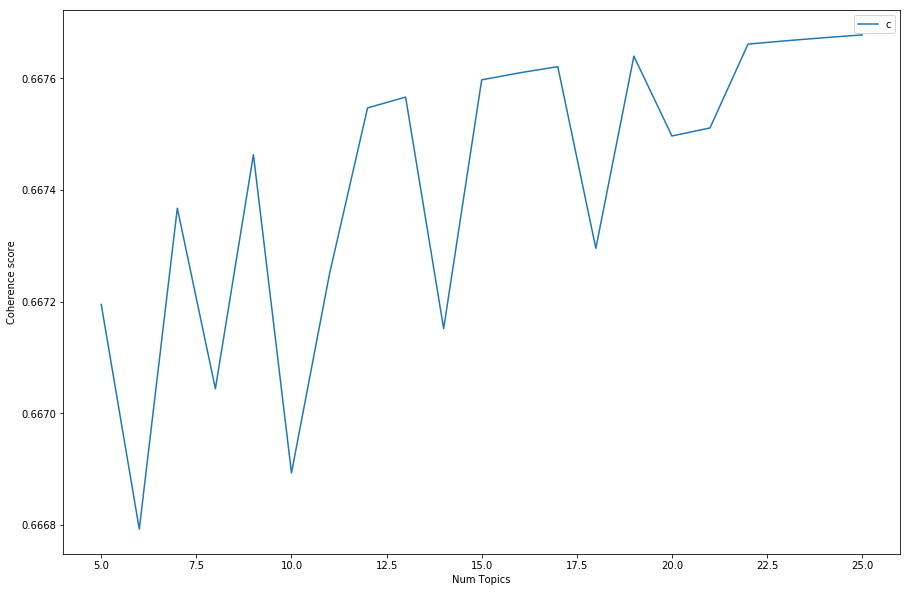

In [162]:
# Show graph
limit=26; start=5; step=1;
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [163]:
ldamallet2 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=title_corpus, num_topics=20, id2word=title_dictionary)

In [164]:
# Show Topics
print(ldamallet2.show_topics(num_topics=1000, formatted=False))
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_ldamallet2 = CoherenceModel(model=ldamallet2, texts=title_data, dictionary=title_dictionary, coherence='c_v')
coherence_ldamallet2 = coherence_model_ldamallet2.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet2)

[(0, [('breitbart', 0.23433242506811988), ('rubio', 0.035422343324250684), ('muslim', 0.02997275204359673), ('presidential', 0.027247956403269755), ('marco', 0.021798365122615803), ('sessions', 0.01634877384196185), ('rally', 0.013623978201634877), ('putin', 0.013623978201634877), ('officer', 0.013623978201634877), ('olympics', 0.013623978201634877)]), (1, [('medium', 0.0446927374301676), ('election', 0.04189944134078212), ('america', 0.036312849162011177), ('record', 0.0223463687150838), ('reveal', 0.0223463687150838), ('unite', 0.01675977653631285), ('explain', 0.01675977653631285), ('announce', 0.01675977653631285), ('steve', 0.01675977653631285), ('official', 0.013966480446927373)]), (2, [('clinton', 0.1329639889196676), ('hillary', 0.0664819944598338), ('death', 0.0332409972299169), ('amazon', 0.01662049861495845), ('surprise', 0.01662049861495845), ('executive', 0.01662049861495845), ('endorse', 0.013850415512465374), ('trial', 0.013850415512465374), ('night', 0.01385041551246537

In [167]:
start=5; stop=25; step=1;
stop += 1
model_list, coherence_values = compute_coherence_values(dictionary=title_dictionary,
                                                        corpus=title_corpus,
                                                        texts=title_data,
                                                        start=start,
                                                        stop=stop,
                                                        step=step)

Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model


In [168]:
coherence_values

[0.6671948712986364,
 0.6672954488334679,
 0.6673672899297761,
 0.6674211707520075,
 0.6674630780581873,
 0.6674966039031311,
 0.6675240341399034,
 0.6675468926705469,
 0.6675662345041684,
 0.667582813218701,
 0.6675971814379628,
 0.6676097536298167,
 0.6676208467402761,
 0.6676307072829066,
 0.6676395298736814,
 0.6676474702053788,
 0.6676546543150095,
 0.6676611853237648,
 0.6676671484187153,
 0.6676726145890864,
 0.667677643465828]

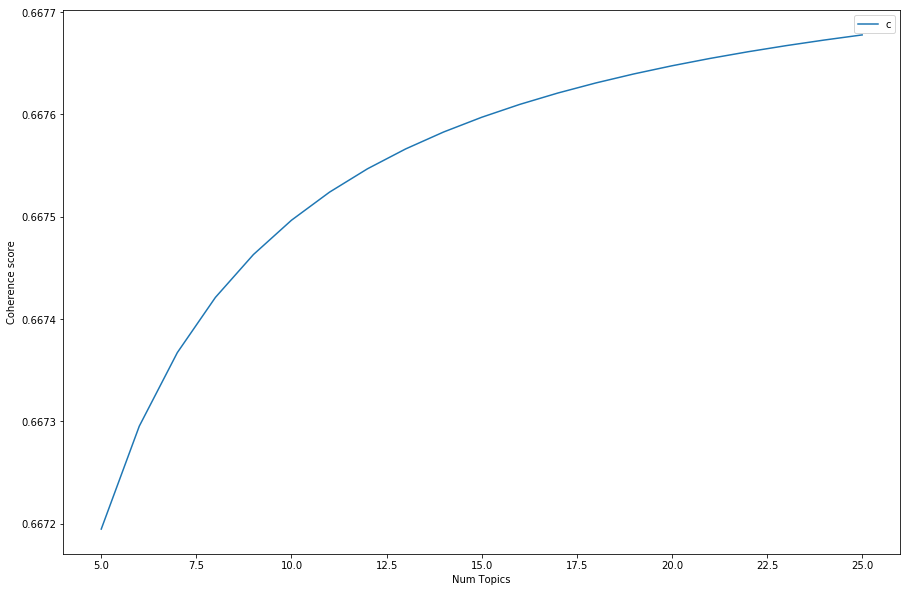

In [169]:
# Show graph
limit=26; start=5; step=1;
x = range(start, limit, step)
plt.figure(figsize=(15, 10))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()